In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
sns.set_color_codes('deep')

In [5]:
RANDOM_STATE = 112
N_MIXTURES_TO_SEARCH_FOR_EACH_K = 3
#CPUS_TO_USE = 16
K_RANGE_TO_SEARCH = [5,6,7,8,9,10,11]
EPSILON = 1e-2 # difference to treat the log likelihood as converged

# Loading data

In [6]:
import sklearn.datasets
digits_dataset = sklearn.datasets.load_digits()
digits = pd.DataFrame(digits_dataset.data)
labels = pd.Series(digits_dataset.target, index=digits.index, name='label')

THRESHOLD = np.mean(digits.values.reshape(-1))
binary_digits = digits >= THRESHOLD

from sklearn.utils import shuffle
binary_digits = shuffle(binary_digits, random_state=RANDOM_STATE)
labels = labels.loc[binary_digits.index]

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [7]:
K=len(labels.unique())
D=len(binary_digits.columns)

In [8]:
def draw_digit(row, vmin=0, vmax=1, square=True, **kwargs):
    return sns.heatmap(row.astype(float).reshape(8, 8), square=square, vmin=vmin, vmax=vmax, **kwargs)

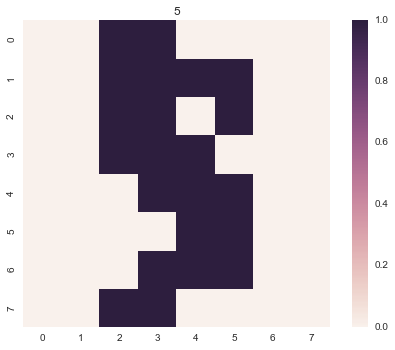

In [9]:
draw_digit(binary_digits.iloc[0])
plt.title(labels.iloc[0])

In [10]:
up_missing = binary_digits.iloc[:len(binary_digits)//4].copy()
bottom_missing = binary_digits.iloc[len(binary_digits)//4:len(binary_digits)//2].copy()
even_missing = binary_digits.iloc[len(binary_digits)//2:].copy()
up_missing.iloc[:, :D//2] = None
bottom_missing.iloc[:, D//2:] = None
even_missing.iloc[:, np.arange(0, D, 2)] = None

up_missing['dataset_id'] = 'up_missing'
bottom_missing['dataset_id'] = 'bottom_missing'
even_missing['dataset_id'] = 'even_missing'

training_data = pd.concat((up_missing, bottom_missing, even_missing))

In [11]:
training_data['weight'] = 1

In [12]:
def label_distribution(data, labels):
    ans = data[['dataset_id', 'weight']].join(labels).groupby(['dataset_id', 'label']).sum()['weight']
    ans /= ans.sum(level='dataset_id')
    
    return ans

# Part 1: Constrained coefficients for datasets

Lump the three datasets into one, call it 'merged' dataset

In [13]:
training_data_same_dataset = training_data.copy()
training_data_same_dataset['dataset_id'] = 'merged'

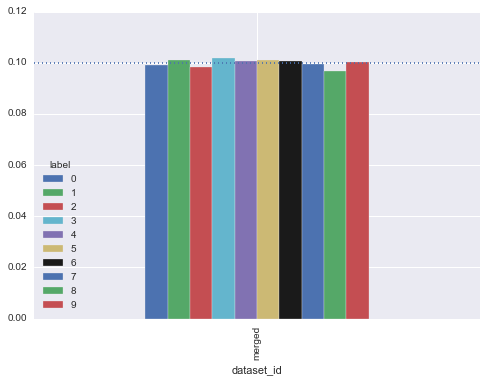

In [14]:
label_distribution(training_data_same_dataset, labels).unstack('label').plot(kind='bar')
plt.axhline(0.1, linestyle=':')

In [15]:
from bernoullimix.random_initialisation import random_mixture_generator

In [16]:
%%time
from bernoullimix.n_components_search import search_k

mixtures, results = search_k(K_RANGE_TO_SEARCH, 
                             training_data_same_dataset, 
                             components_per_k=N_MIXTURES_TO_SEARCH_FOR_EACH_K, 
                             random_state=RANDOM_STATE, 
                             verbose=False, eps=EPSILON, n_iter=None)

CPU times: user 1min 45s, sys: 1.27 s, total: 1min 46s
Wall time: 1min 44s


/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]


Min BIC: 9


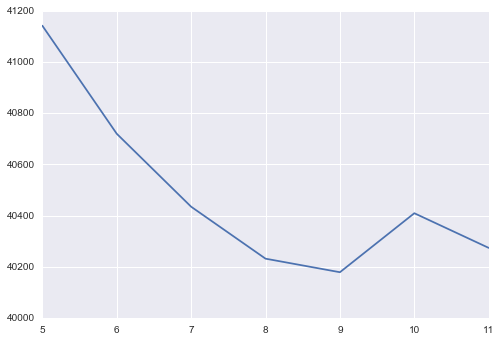

In [17]:
results['BIC'].plot()
print('Min BIC: {}'.format(results['BIC'].argmin()))

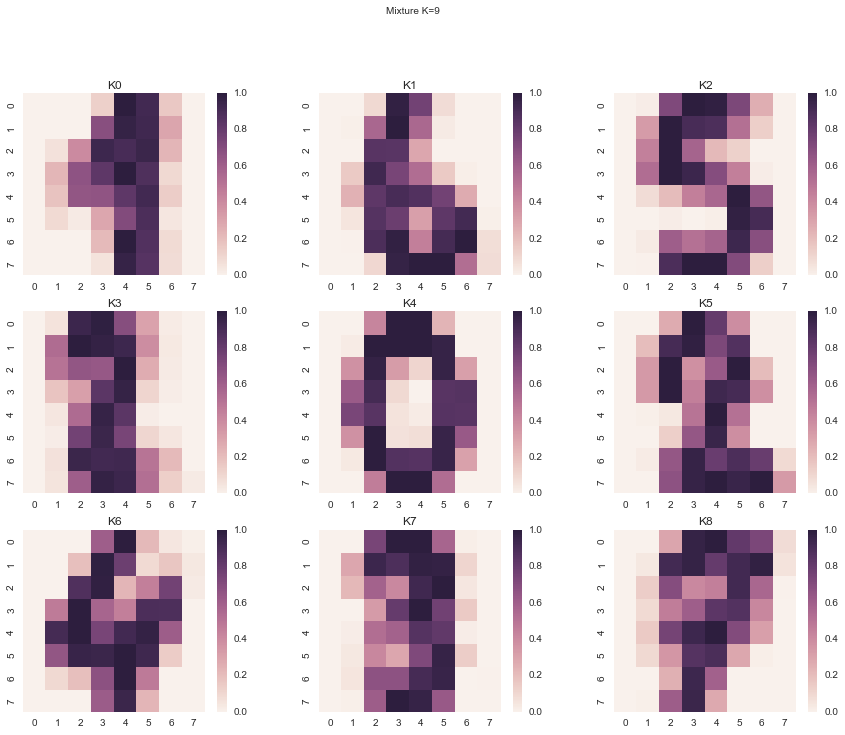

In [18]:
best_mixture = mixtures[results['BIC'].argmin()]
plt.figure(figsize=(15,15))
for j, (component, row) in enumerate(best_mixture.emission_probabilities.iterrows(), start=1):
    plt.subplot(4,3,j)
    draw_digit(row)
    plt.title(component)
plt.suptitle('Mixture K={}'.format(best_mixture.n_components))

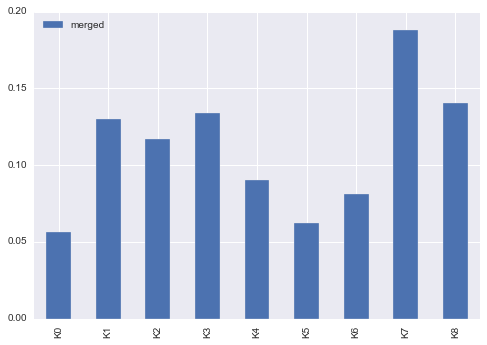

In [25]:
best_mixture.mixing_coefficients.T.plot(kind='bar')

# Unconstrained mixture

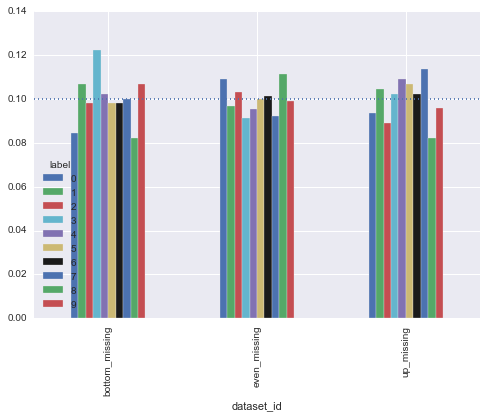

In [20]:
label_distribution(training_data, labels).unstack('label').plot(kind='bar')
plt.axhline(0.1, linestyle=':')

In [21]:
%%time
from bernoullimix.n_components_search import search_k

mixtures_uc, results_uc = search_k(K_RANGE_TO_SEARCH, 
                                   training_data, 
                                   components_per_k=N_MIXTURES_TO_SEARCH_FOR_EACH_K, 
                                   random_state=RANDOM_STATE, 
                                   verbose=False, eps=EPSILON, n_iter=None)

CPU times: user 58 s, sys: 430 ms, total: 58.4 s
Wall time: 57.8 s


/home/saulius/dev/bernoulli-mixture-model/bernoullimix/random_initialisation.py:140: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  data = dataset[dataset.columns - [DATASET_ID_COLUMN, WEIGHT_COLUMN]]


Min BIC: 9


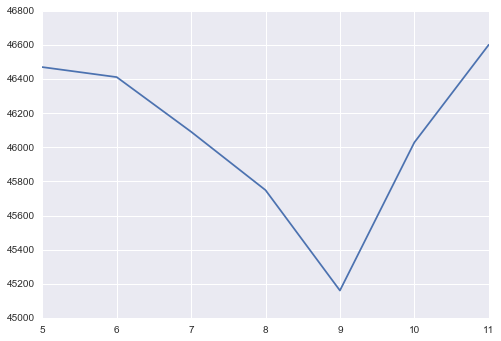

In [22]:
results_uc['BIC'].plot()
print('Min BIC: {}'.format(results_uc['BIC'].argmin()))

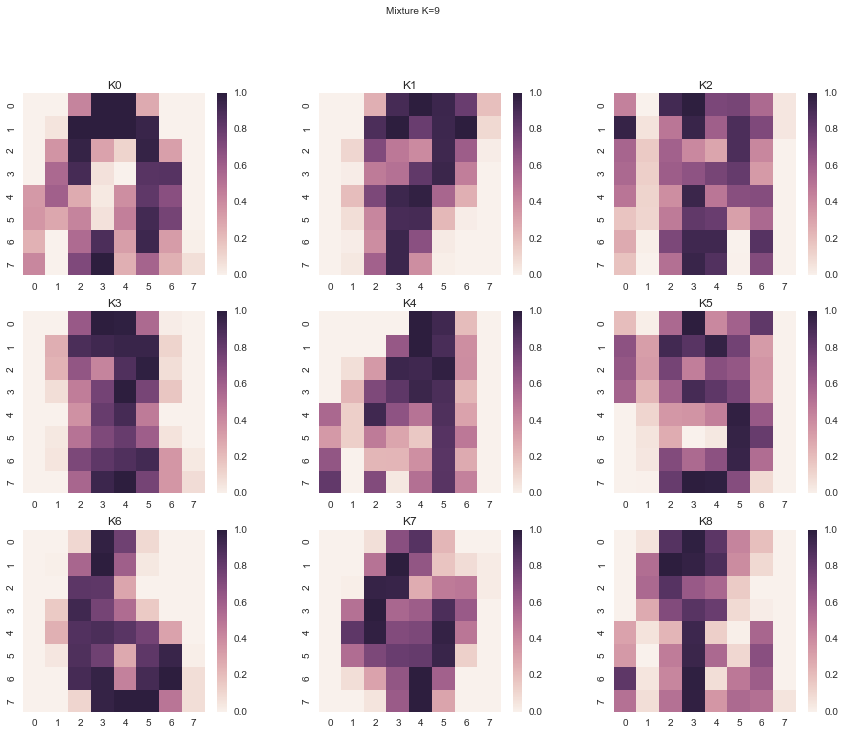

In [23]:
best_mixture_uc = mixtures_uc[results_uc['BIC'].argmin()]
plt.figure(figsize=(15,15))
for j, (component, row) in enumerate(best_mixture_uc.emission_probabilities.iterrows(), start=1):
    plt.subplot(4,3,j)
    draw_digit(row)
    plt.title(component)
plt.suptitle('Mixture K={}'.format(best_mixture_uc.n_components))

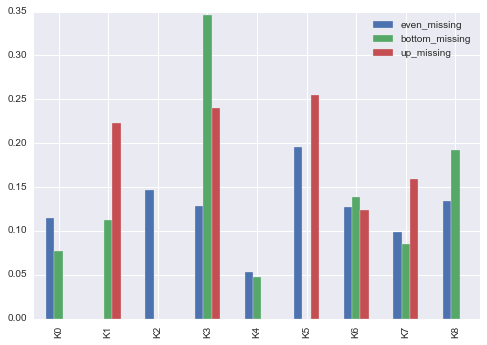

In [26]:
best_mixture_uc.mixing_coefficients.T.plot(kind='bar')